## Groups and users

Folder with files: https://drive.google.com/drive/folders/1F-pm_J-eKZAd7-PxnzZdCpKfAMlFs6Ke?usp=sharing

You may add a shortcut to your drive and run this code on colab OR download files from gdrive and run locally.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !pip install vk_api

In [3]:
import itertools
import vk_api
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from tqdm import tqdm

In [4]:
groups_and_users = pd.read_csv("/content/drive/My Drive/Angl/Группы и пользователи.csv", header=None)
groups_and_users.columns = ['Group', 'Users']
groups_and_users.head()

,Group,Users
0,VK_-137472625,"[101435, 105801, 191330, 353156, 485967, 66426..."
1,VK_-110896651,"[780934, 830001, 836222, 1004278, 1665190, 233..."
2,VK_-196351490,[518436379]
3,VK_-184898993,"[88448, 493832, 1591629, 2534553, 4198909, 428..."
4,VK_-164251213,"[5206505, 45741508, 58873119, 79030324, 132966..."


In [5]:
groups_with_users = groups_and_users['Group'].tolist()
print('Number of groups:', len(groups_with_users))

Number of groups: 9887


### 1. Create graph

We create a graph on all groups that we extracted.

Nodes are groups and their members.

There is an egde (group_i, user_j) if user_j is a member of group_i.

In [6]:
def create_graph(groups_and_users, sample_groups):
    G = nx.Graph()
    G.add_nodes_from(sample_groups)
    
    users = set()

    for row_id in tqdm(range(len(groups_and_users))):
        group = groups_and_users.iloc[row_id]['Group']
        if group in sample_groups:
            group_users = groups_and_users.iloc[row_id]['Users'][2:-2].split(', ')
            for user in group_users:
                users.add(user)
            edges = [(group, user) for user in group_users]
            G.add_edges_from(edges)

    print('\nGraph created...')
    print('Number of nodes:', G.number_of_nodes())
    print('Number of users:', len(users))
    print('Number of edges:', G.number_of_edges())

    return G, list(users)

In [7]:
G, users_G = create_graph(groups_and_users, groups_with_users)

100%|██████████| 9887/9887 [00:31<00:00, 311.43it/s]



Graph created...
Number of nodes: 4127357
Number of users: 4117470
Number of edges: 5917848


### 2. Top groups

We extract the most active groups. The "activness" is measured by the (overall, not unique) number of anglicisms used.

In [8]:
posts_info = pd.read_csv("/content/drive/My Drive/Angl/posts_info.csv")
posts_info.head(3)

,Unnamed: 0,AuthorID,OwnerID,CreatedDate,SearchQuery,AuthorType,OwnerType
0,0,VK_-137472625,VK_-137472625,2020-06-16,войс,0,0
1,1,VK_-110896651,VK_-110896651,2020-06-16,войс,0,0
2,2,VK_-196351490,VK_-196351490,2020-06-15,войс,0,0


In [9]:
posts_info_groups = posts_info[posts_info['OwnerType'] == 0]
groups_counts = dict(posts_info_groups.groupby('OwnerID').size())
print('Number of unique groups in posts_info:', len(groups_counts))

Number of unique groups in posts_info: 25950


In [24]:
# sort to extract top groups

sorted_groups_counts = [(k, v) for k, v in sorted(groups_counts.items(), key=lambda item: item[1])]

In [11]:
# top 10 active groups

sorted_groups_counts[-10:]

[('VK_-52079251', 43),
 ('VK_-72739547', 47),
 ('VK_-163818203', 49),
 ('VK_-171963681', 51),
 ('VK_-46035363', 56),
 ('VK_-140691640', 60),
 ('VK_-17985992', 95),
 ('VK_-190838425', 106),
 ('VK_-130326293', 114),
 ('VK_-72562540', 144)]

### 3. Visualization of the graph on top 10 groups

Since the graph on all groups is too large, we visualize a subgraph on 10 groups.

In [12]:
sample_groups_0 = []

for group, _ in sorted_groups_counts[::-1]:
    if group in groups_with_users:
        sample_groups_0.append(group)
        if len(sample_groups_0) == 10:
            break

subG_0, users_subG_0 = create_graph(groups_and_users, sample_groups_0)

100%|██████████| 9887/9887 [00:01<00:00, 8692.62it/s]


Graph created...
Number of nodes: 5071
Number of users: 5061
Number of edges: 5062


In [13]:
pos = nx.spring_layout(subG_0)

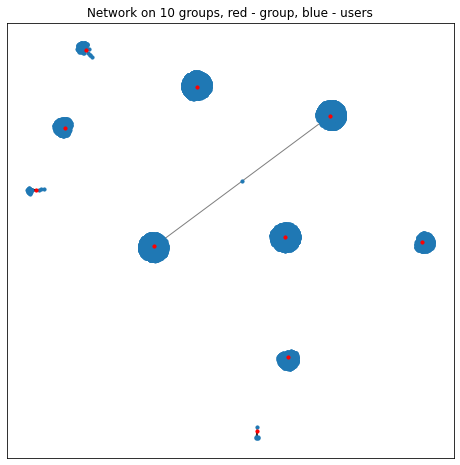

In [14]:
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(subG_0, pos, users_subG_0, node_size=10)
nx.draw_networkx_nodes(subG_0, pos, sample_groups_0, node_size=10, node_color='r')
nx.draw_networkx_edges(subG_0, pos, alpha=0.5)
plt.title('Network on 10 groups, red - group, blue - users')
plt.show()

It can be seen that selected groups do not have common members (except two groups that have only common one member).

### 4. Analysis for subgraph on top 200 groups

In this part, we analyse similarity of anglicisms and groups. We take top 200 groups and compute jaccard index for all pairs of groups. Then, we take pairs with the largest jaccard coefficient and gather the following information about them:

* names
* descriptions
* anglicisms used

In [15]:
# take 200 top groups

sample_groups = []

for group, _ in sorted_groups_counts[::-1]:
    if group in groups_with_users:
        sample_groups.append(group)
        if len(sample_groups) == 200:
            break

subG, users_subG = create_graph(groups_and_users, sample_groups)

100%|██████████| 9887/9887 [00:01<00:00, 6350.05it/s]


Graph created...
Number of nodes: 116581
Number of users: 116381
Number of edges: 118891


#### Jaccard coefficient between groups

In [16]:
group_pairs = itertools.product(sample_groups, sample_groups) # 40 000
jaccard_subG = nx.jaccard_coefficient(subG, ebunch=group_pairs)
jaccard_coeffs = []
count = 0

for pair in jaccard_subG:
    if pair[0] != pair[1]:
        jaccard_coeffs.append(pair)
    if (count + 1) % 5000 == 0:
        print('Done, ', count + 1)
    count += 1

Done,  5000
Done,  10000
Done,  15000
Done,  20000
Done,  25000
Done,  30000
Done,  35000
Done,  40000


In [17]:
jaccard_sorted = sorted(jaccard_coeffs, key = lambda item: item[2])[::2] # each pair appears twice

In [18]:
# top similar pairs

jaccard_sorted[-10:]

[('VK_-190838425', 'VK_-96261838', 0.021450459652706845),
 ('VK_-172592337', 'VK_-175904320', 0.024077868852459015),
 ('VK_-367805', 'VK_-153654264', 0.0336676217765043),
 ('VK_-67339967', 'VK_-176319013', 0.035732780942516834),
 ('VK_-172592337', 'VK_-94742076', 0.043319415448851775),
 ('VK_-193037104', 'VK_-33602050', 0.04931794333683106),
 ('VK_-136166858', 'VK_-136166844', 0.049868766404199474),
 ('VK_-86678270', 'VK_-72090109', 0.325),
 ('VK_-134463812', 'VK_-72090109', 0.3939393939393939),
 ('VK_-86678270', 'VK_-134463812', 0.41025641025641024)]

In [19]:
login = ### ENTER YOUR LOGIN HERE
password = ### ENTER YOUR PASSWORD HERE
vk_session = vk_api.VkApi(login, password)
vk_session.auth()

vk = vk_session.get_api()

In [20]:
# dataframe with results

top_jaccard_groups = pd.DataFrame(columns=['Jaccard',
                                           'Group_1_id',
                                           'Group_1_name',
                                           'Group_2_id',
                                           'Group_2_name',
                                           'Group_1_words',
                                           'Group_2_words',
                                           'Group_1_desc',
                                           'Group_2_desc',
                                           ])

In [21]:
top_jaccard = jaccard_sorted[-20:]

for pair in top_jaccard[::-1]:
    group_1_info = vk.groups.getById(group_ids=pair[0][4:], fields='description')
    group_2_info = vk.groups.getById(group_ids=pair[1][4:], fields='description')

    group_1_words = posts_info_groups[posts_info_groups['OwnerID'] == pair[0]]['SearchQuery'].unique().tolist()
    group_2_words = posts_info_groups[posts_info_groups['OwnerID'] == pair[1]]['SearchQuery'].unique().tolist()

    pair_info = {'Jaccard': pair[2],
                 'Group_1_id': pair[0][4:],
                 'Group_1_name': group_1_info[0]['name'],
                 'Group_2_id': pair[1][4:],
                 'Group_2_name': group_2_info[0]['name'],
                 'Group_1_words': group_1_words,
                 'Group_2_words': group_2_words,
                 'Group_1_desc': group_1_info[0]['description'],
                 'Group_2_desc': group_2_info[0]['description']}

    top_jaccard_groups = top_jaccard_groups.append(pair_info, ignore_index=True)

In [22]:
top_jaccard_groups

,Jaccard,Group_1_id,Group_1_name,Group_2_id,Group_2_name,Group_1_words,Group_2_words,Group_1_desc,Group_2_desc
0,0.410256,86678270,Студия Аналитики,134463812,Reddit-Life. Dota 2,"[ультимейт, глобал, хайграунд, дамажить, ачивка]","[ультимейт, хайграунд, дамажить, ачивка, импакт]","Новости о Dota 2, киберспорте и жизни киберспо...","Место, где живут все драмы из мира Dota 2.\n\n..."
1,0.393939,134463812,Reddit-Life. Dota 2,72090109,Киберспорт и игры,"[ультимейт, хайграунд, дамажить, ачивка, импакт]","[ультимейт, хайграунд, ачивка, апать, импакт, ...","Место, где живут все драмы из мира Dota 2.\n\n...","Все новости лучших видеоигр мира: Dota 2, CS:G..."
2,0.325000,86678270,Студия Аналитики,72090109,Киберспорт и игры,"[ультимейт, глобал, хайграунд, дамажить, ачивка]","[ультимейт, хайграунд, ачивка, апать, импакт, ...","Новости о Dota 2, киберспорте и жизни киберспо...","Все новости лучших видеоигр мира: Dota 2, CS:G..."
3,0.049869,136166858,Vape Барахолка Нижний Новгород | Вейп,136166844,Vape Барахолка Пенза | Вейп,[вейпер],[вейпер],Vape Нижний Новгород – электронные сигареты Ни...,Vape Пенза – электронные сигареты Пенза. В наш...
4,0.049318,193037104,Revolution Trading,33602050,Поиск Ролевиков | Соигроков | Конференции,"[брифинг, инсайд]","[гейм, ультимейт, абьюз, лайкооткликаемо]","Информация, представленная в сообществе, носит...",
5,0.043319,172592337,Stopgame.ru News,94742076,ИЩУ_ДИЗАЙНЕРА,"[геймер, геймплей, гифка, девелопер, ачивка]","[гайдлайн, гейм]","Подпишись, чтобы быть в курсе самых горячих и ...","Свежие вакансии для дизайнеров. Как в офис, та..."
6,0.035733,67339967,Дерзкий Волк,176319013,Эротические гифки [мемы/секс/порно/Brazzers],[гифка],[гифка],,Здесь вы найдете лучшие эротические гифки\n⛔ З...
7,0.033668,367805,ProJapan: доставка мотоциклов из Японии.,153654264,"Женская одежда ""AVILI"" И ""CHARUTTI""","[фазер, хаггер]","[вау, изи, кэжуал]",Привозим любые мотоциклы из Японии под заказ в...,Добро пожаловать в группу! Высокое качество од...
8,0.024078,172592337,Stopgame.ru News,175904320,"СОВМЕСТНЫЕ ПОКУПКИ ""МАМКИ"" ЧЕРЕПОВЕЦ","[геймер, геймплей, гифка, девелопер, ачивка]","[бэби, глиттер, блэкаут]","Подпишись, чтобы быть в курсе самых горячих и ...",Рады приветствовать Вас в нашей группе!\n\nЗде...
9,0.021450,190838425,ТУРЫ без комиссии,96261838,VAPE УЛЬЯНОВСК,[райтинг],[вейпер],ТУРЫ без комиссии - это...\n💰 Выгодно: здесь В...,Vape Ульяновск – электронные сигареты Ульяновс...


In [23]:
top_jaccard_groups.to_csv('/content/drive/My Drive/Angl/top_jaccard_groups.csv', index=None)

It can be seen that the highest jaccard index is 0.41 which is surprisingly high taking into account the fact that the limit of the number of group members is 1000 :)

As for the set of pairs with top jaccard index, there are a lot of groups about games (especially Dota 2) and their common anglicisms are [ультимейт, глобал, хайграунд, дамажить, ачивка] which is expectable.

We can make a conclusion that it is possible to get information about anglicisms and their connections with such a data. Moreover, the results are pretty interesting to observe)

Further reserach:

1) Increase the vocabulary and gather more data.

2) Run the analysis on larger data.

3) Research not only groups but also users connections.

4) Clusterization and extraction of clusters of words: try to unite words in groups.

